In [245]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples, explained_variance_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 200

# Basic exploration

Read listings file

In [246]:
listings = pd.read_csv('../data/za_sample_listings_incl_cat.csv', index_col=0)

Print first rows

In [252]:
listings.head()

,item_id,seller_id,listing_title,listing_description,listing_price,category_sk,category_l1_name_en,category_l2_name_en,category_l3_name_en,listing_latitude,listing_longitude
0.0,0.0,0,Nice wooden makes,We build all different types for sale,17500.00,olx|mea|za|806|809,"Home, Garden & Tools",Garden & Braai,Unknown,-25.43067,27.84873
1.0,1.0,1,A Shinning 2013 Chevrolet 1.4 Utility Bakkie with FSH amd all extras!,A Stunning accident free bargain that has just arrived at our dealership with all extras and sho...,94890.00,olx|mea|za|362|378|2012,Vehicles,Cars & Bakkies,Chevrolet,-29.73714,31.07364
2.0,2.0,2,Lampshades various,A variety of lampshades in white,20.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.88159,18.55522
3.0,3.0,3,Toyota Corolla,"Toyota Corolla 1.3 Professional, Front Electric windows front only, CD front loader, power steer...",63995.00,olx|mea|za|362|378|2067,Vehicles,Cars & Bakkies,Toyota,-26.10757,28.05670
4.0,4.0,4,bench grinder and buffer,bench grinder and.buffer...R800 for both,800.00,olx|mea|za|806|910,"Home, Garden & Tools",Tools & DIY,Unknown,-26.17190,27.91318


Print column types

In [5]:
listings.dtypes

item_id                float64
seller_id               object
listing_title           object
listing_description     object
listing_price           object
category_sk             object
category_l1_name_en     object
category_l2_name_en     object
category_l3_name_en     object
listing_latitude       float64
listing_longitude      float64
dtype: object

How many listings?

In [6]:
n_listings = listings.shape[0]
print("There are {} listings".format(n_listings))

There are 500016 listings


How many sellers?

In [7]:
n_sellers = listings.seller_id.nunique(dropna=False)
print("There are {} sellers".format(n_sellers))

There are 198664 sellers


How many listings per seller?

<IPython.core.display.Javascript object>


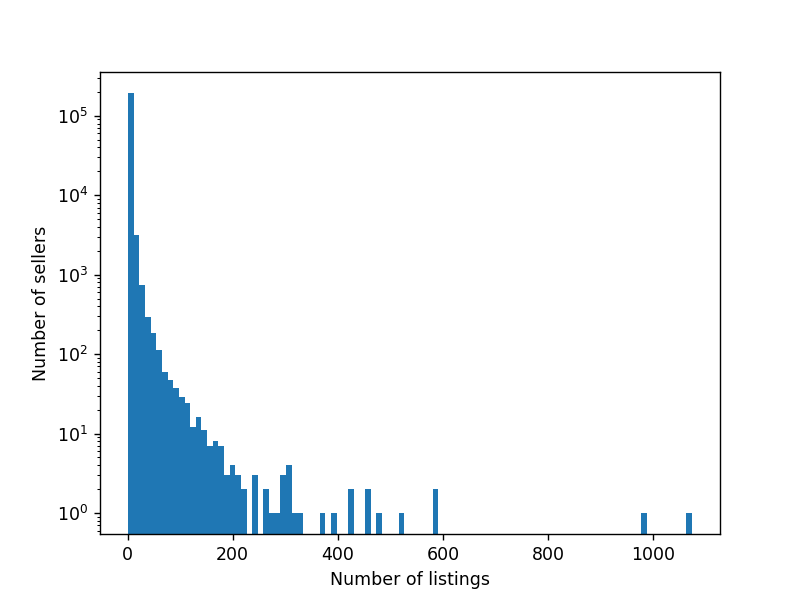

In [9]:
%matplotlib notebook
listings_per_id = listings.seller_id.value_counts(dropna=False)
plt.hist(listings_per_id.values, 100, log=True)
plt.xlabel('Number of listings')
plt.ylabel('Number of sellers')
plt.show()

Based on the plot above, it is clear that a very large proportion of the sellers have posted a really low number of items. Let us check some concrete numbers.

In [10]:
n_sellers_single_item = sum(listings_per_id == 1)
n_sellers_less_than_10_items = sum(listings_per_id <= 10)
print('{} sellers ({:.2f} % of the sellers) posted only one item'.format(
    n_sellers_single_item, 100 * n_sellers_single_item/float(n_sellers)))
print('{} sellers ({:.2f} % of the sellers) posted less than 10 items'.format(
    n_sellers_less_than_10_items, 100 * n_sellers_less_than_10_items/float(n_sellers)))

123399 sellers (62.11 % of the sellers) posted only one item
193113 sellers (97.21 % of the sellers) posted less than 10 items


How many listings per category and subcategory?

In [15]:
listings.groupby(['category_l1_name_en', 'category_l2_name_en']).item_id.count()

category_l1_name_en      category_l2_name_en                  
Electronics & Computers  Cameras                                    3182
                         Cell Phones                               28266
                         Computer Hardware & Accessories            6327
                         Computers & Laptops                       10876
                         Gaming & Consoles                         11468
                         TV, Audio & Visual                        11323
                         iPads & Tablets                            3036
Farming & Industrial     Business & Industrial Equipment            6871
                         Farming Equipment & Vehicles               3533
                         Feeds, Supplements & Seeds                  680
                         Livestock                                  3292
Fashion & Beauty         Clothing & Shoes                           6694
                         Health, Beauty & Cosmetics          

Let us take a look at the length distribution for listing titles

<IPython.core.display.Javascript object>


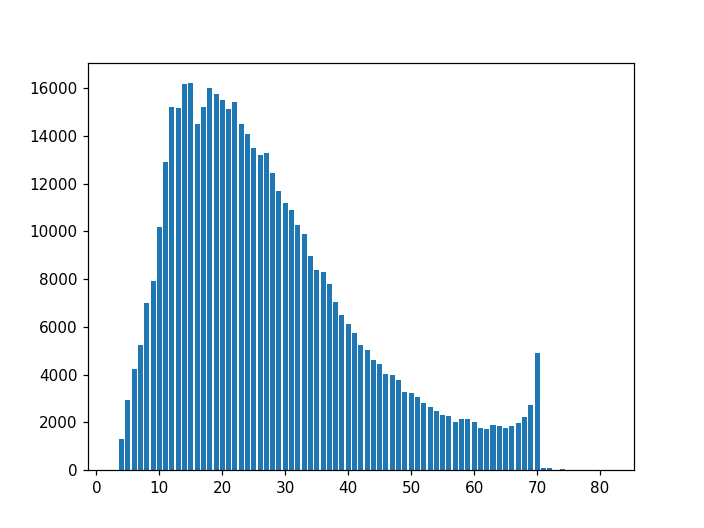

<BarContainer object of 78 artists>

In [260]:
%matplotlib notebook
lens_titles = listings.listing_title.str.len()
lens_titles_counts = lens_titles.value_counts()
plt.bar(lens_titles_counts.index.tolist(), lens_titles_counts.values.tolist())

Based on the plot above, mean length is around 25. Note however the tail extending up to 70. Most probably, 70 is close to the max number of characters allowed for the title (the bump observed around 75 is probably due to people wanting to use every available character) 

Let us now take a look at the length distribution for listing descriptions.

<IPython.core.display.Javascript object>


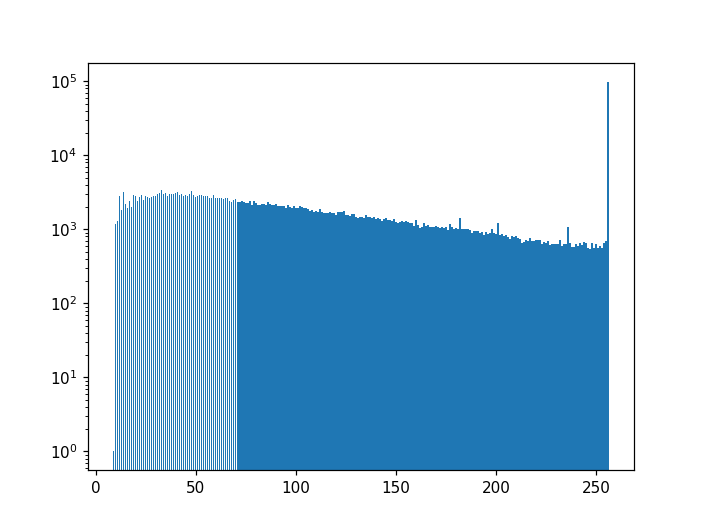

<BarContainer object of 248 artists>

In [271]:
%matplotlib notebook
lens_desc = listings.listing_description.str.len()
lens_desc_counts = lens_desc.value_counts()
plt.bar(lens_desc_counts.index.tolist(), lens_desc_counts.values.tolist(), log=True)

As expected, lengths are larger than in the case of titles. Note how a large part of the listings use every available character (256) for the description.

Let us now take a look at the queries file

In [255]:
queries = pd.read_csv('../data/za_queries_sample.csv', index_col=0)

Print first rows

In [164]:
queries.head(10)

,search_term,cnt
0,polo,133394
1,golf,124172
2,isuzu,121043
3,bmw,109099
4,toyota corolla,107486
5,toyota,99802
6,hilux,95592
7,toyota tazz,94877
8,cars,93824
9,bakkie,89243


How many queries?

In [258]:
n_queries = queries.shape[0]
print('There are {} queries'.format(n_queries))

There are 100000 queries


# Clustering (Item 2-a of the case study)

Let us implement a very basic clustering approach. Actually, in consists of several clusterings. We leverage the current categories and subcategories assigned by the sellers and we cluster the items within each subcategory. This fixes the categories and subcategories for recomendation, effectively reducing flexibility (see item 2-c below), but it is reasonable as a first approach to the problem.

For each subcategory, we follow a quite standard text clustering approach. First, each item title is transformed into a feature vector where the different components of the vector correspond to the tfidf values of different terms found in the titles. Then, the vector dimensionality is reduced by means of LSA. Finally, we do mini batch k-means for clustering.

Let us first define the number of feature to use for building the vectors. As mentioned above, we will make sure to end up with this number of features by performing LSA on the vectors generated by the tf-idf vectorizer.

In [13]:
n_features = 30

Let us put the code for dimensionality reduction into a function, as we will use it a couple of times below.

In [42]:
def reduce_dim(X_raw, n):
    svd = TruncatedSVD(n)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X_raw)
    explained_variance = svd.explained_variance_ratio_.sum()
    return (X, explained_variance)

Let us know perform the clusterings.

In [136]:
import warnings
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
warnings.filterwarnings('ignore')

# There are a few records with null listing_title, category or subcategory
listings.dropna(subset=['listing_title', 'category_l1_name_en', 'category_l2_name_en'], inplace=True)

# Dictionary where the clusterings will be saved
clusterings = {}

# Iterate over the different subcategories
sub_categories = listings.category_l2_name_en.unique()
nsc = len(sub_categories)
for i, sc in enumerate(sub_categories):
    printmd('Computing clusters for sub-category **{}** ({} out of {})'.format(sc, i, nsc))
    listings_cat = listings[listings.category_l2_name_en == sc].copy()
    
    # Replace Money strings (most of them anyway) by a specific token to avoid multiple useless features
    titles = listings_cat.listing_title.str.replace('\\b[r|R]\\s*[0-9]+\\s*[,|.]*\\s*[0-9]*', 'MONEYTOKEN') 
    titles = titles.str.replace('\\b[0-9]+[,|\\s|\\.][0-9]+', 'MONEYTOKEN')

    # Remove also a few common words than might not be useful as features (this sould be done more carefully)
    titles = titles.str.lower()
    titles = titles.str.replace('rent', '')
    titles = titles.str.replace('Rent', '')
    titles = titles.str.replace('sale', '')
    titles = titles.str.replace('Sale', '')

    # Vectorize
    print("\tComputing tfidf vectors...".format(n_features_raw))
    vectorizer = TfidfVectorizer(stop_words='english', min_df=0.0005)
    features_raw = vectorizer.fit_transform(titles)
    n_features_raw = len(vectorizer.get_feature_names())

    # Basic sanity check
    print("\t\tNumber of features per listing: {}".format(n_features_raw))
    n_listings_cat = listings_cat.shape[0]
    n_all_zero = sum(features_raw_df.sum(axis=1) == 0)
    print('\t\t{} listings ({:.2f} % of the listings) have only zero valued features'.format(
        n_all_zero, 100 * n_all_zero/float(n_listings_cat)))
    
    # Reduce dimensionality
    print("\tReducing dimensionality...")
    features, explained_variance = reduce_dim(features_raw, n_features)
    print('\t\tExplained variance with SVD: {:.2f} %'.format(int(explained_variance * 100)))
    
    # Choose best number of clusters (for k-means)
    print('\tChoosing best number of clusters...')
    best_n_clusters = -1
    best_score = -1
    for n_clusters in [5, 10, 20, 40]:
        print('\t\tTesting with {} clusters...'.format(n_clusters))
        k_means = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=5, init_size=1000, 
                        batch_size=1000, verbose=0)
        k_means.fit(features)

        # Print clustering quality measures
        score = silhouette_score(features, k_means.labels_, sample_size=1000)
        print('\t\t\tSilhouette Coefficient: {:0.3f}'.format(score))
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters
    
    # Clusterize using the best option among the explored ones
    k_means = MiniBatchKMeans(n_clusters=best_n_clusters, init='k-means++', n_init=5, init_size=1000, 
                            batch_size=1000, verbose=0)
    k_means.fit(features)
    clusterings[sc] = {}
    clusterings[sc]['labels'] = k_means.labels_
    clusterings[sc]['silhouette_score'] = best_score

Computing clusters for sub-category **Garden & Braai** (0 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 956
		513 listings (9.00 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 54.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.122
		Testing with 10 clusters...
			Silhouette Coefficient: 0.183
		Testing with 20 clusters...
			Silhouette Coefficient: 0.267
		Testing with 40 clusters...
			Silhouette Coefficient: 0.330


Computing clusters for sub-category **Cars & Bakkies** (1 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 800
		513 listings (0.33 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 54.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.075
		Testing with 10 clusters...
			Silhouette Coefficient: 0.118
		Testing with 20 clusters...
			Silhouette Coefficient: 0.183
		Testing with 40 clusters...
			Silhouette Coefficient: 0.230


Computing clusters for sub-category **Furniture & Decor** (2 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 793
		513 listings (1.63 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 57.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.092
		Testing with 10 clusters...
			Silhouette Coefficient: 0.123
		Testing with 20 clusters...
			Silhouette Coefficient: 0.196
		Testing with 40 clusters...
			Silhouette Coefficient: 0.259


Computing clusters for sub-category **Tools & DIY** (3 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1019
		513 listings (5.60 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 46.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.070
		Testing with 10 clusters...
			Silhouette Coefficient: 0.119
		Testing with 20 clusters...
			Silhouette Coefficient: 0.163
		Testing with 40 clusters...
			Silhouette Coefficient: 0.258


Computing clusters for sub-category **Homeware & Appliances** (4 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 815
		513 listings (3.35 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 57.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.086
		Testing with 10 clusters...
			Silhouette Coefficient: 0.105
		Testing with 20 clusters...
			Silhouette Coefficient: 0.138
		Testing with 40 clusters...
			Silhouette Coefficient: 0.217


Computing clusters for sub-category **Transport** (5 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 600
		513 listings (10.09 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 75.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.172
		Testing with 10 clusters...
			Silhouette Coefficient: 0.263
		Testing with 20 clusters...
			Silhouette Coefficient: 0.337
		Testing with 40 clusters...
			Silhouette Coefficient: 0.378


Computing clusters for sub-category **Car Parts & Accessories** (6 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1011
		513 listings (1.38 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 47.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.055
		Testing with 10 clusters...
			Silhouette Coefficient: 0.085
		Testing with 20 clusters...
			Silhouette Coefficient: 0.141
		Testing with 40 clusters...
			Silhouette Coefficient: 0.166


Computing clusters for sub-category **Houses & Flats for sale** (7 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1029
		513 listings (14.14 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 56.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.105
		Testing with 10 clusters...
			Silhouette Coefficient: 0.168
		Testing with 20 clusters...
			Silhouette Coefficient: 0.205
		Testing with 40 clusters...
			Silhouette Coefficient: 0.286


Computing clusters for sub-category **Health, Beauty & Cosmetics** (8 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1318
		513 listings (14.36 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 44.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.072
		Testing with 10 clusters...
			Silhouette Coefficient: 0.096
		Testing with 20 clusters...
			Silhouette Coefficient: 0.163
		Testing with 40 clusters...
			Silhouette Coefficient: 0.243


Computing clusters for sub-category **Computer Hardware & Accessories** (9 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 983
		513 listings (8.11 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 48.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.059
		Testing with 10 clusters...
			Silhouette Coefficient: 0.087
		Testing with 20 clusters...
			Silhouette Coefficient: 0.129
		Testing with 40 clusters...
			Silhouette Coefficient: 0.182


Computing clusters for sub-category **Cell Phones** (10 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 485
		513 listings (1.81 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 73.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.096
		Testing with 10 clusters...
			Silhouette Coefficient: 0.100
		Testing with 20 clusters...
			Silhouette Coefficient: 0.144
		Testing with 40 clusters...
			Silhouette Coefficient: 0.222


Computing clusters for sub-category **Office Furniture & Equipment** (11 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 793
		513 listings (19.98 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 60.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.085
		Testing with 10 clusters...
			Silhouette Coefficient: 0.143
		Testing with 20 clusters...
			Silhouette Coefficient: 0.168
		Testing with 40 clusters...
			Silhouette Coefficient: 0.219


Computing clusters for sub-category **Pet Care & Accessories** (12 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1171
		513 listings (29.53 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 64.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.149
		Testing with 10 clusters...
			Silhouette Coefficient: 0.183
		Testing with 20 clusters...
			Silhouette Coefficient: 0.267
		Testing with 40 clusters...
			Silhouette Coefficient: 0.333


Computing clusters for sub-category **Dogs & Cats** (13 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 509
		513 listings (7.15 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 70.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.068
		Testing with 10 clusters...
			Silhouette Coefficient: 0.121
		Testing with 20 clusters...
			Silhouette Coefficient: 0.176
		Testing with 40 clusters...
			Silhouette Coefficient: 0.238


Computing clusters for sub-category **Jewellery & Accessories** (14 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 756
		513 listings (12.27 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 58.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.078
		Testing with 10 clusters...
			Silhouette Coefficient: 0.106
		Testing with 20 clusters...
			Silhouette Coefficient: 0.157
		Testing with 40 clusters...
			Silhouette Coefficient: 0.215


Computing clusters for sub-category **Businesses for Sale** (15 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1739
		513 listings (34.66 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 44.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.081
		Testing with 10 clusters...
			Silhouette Coefficient: 0.105
		Testing with 20 clusters...
			Silhouette Coefficient: 0.132
		Testing with 40 clusters...
			Silhouette Coefficient: 0.235


Computing clusters for sub-category **Business & Industrial Equipment** (16 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1217
		513 listings (7.47 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 42.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.072
		Testing with 10 clusters...
			Silhouette Coefficient: 0.091
		Testing with 20 clusters...
			Silhouette Coefficient: 0.119
		Testing with 40 clusters...
			Silhouette Coefficient: 0.184


Computing clusters for sub-category **Houses & Flats for rent** (17 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 818
		513 listings (5.50 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 61.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.105
		Testing with 10 clusters...
			Silhouette Coefficient: 0.135
		Testing with 20 clusters...
			Silhouette Coefficient: 0.169
		Testing with 40 clusters...
			Silhouette Coefficient: 0.203


Computing clusters for sub-category **Shop & Catering Equipment** (18 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1779
		513 listings (27.14 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 47.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.069
		Testing with 10 clusters...
			Silhouette Coefficient: 0.088
		Testing with 20 clusters...
			Silhouette Coefficient: 0.126
		Testing with 40 clusters...
			Silhouette Coefficient: 0.206


Computing clusters for sub-category **Art, Collectibles & Rare Items** (19 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1301
		513 listings (9.51 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 42.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.053
		Testing with 10 clusters...
			Silhouette Coefficient: 0.108
		Testing with 20 clusters...
			Silhouette Coefficient: 0.124
		Testing with 40 clusters...
			Silhouette Coefficient: 0.208


Computing clusters for sub-category **TV, Audio & Visual** (20 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 780
		513 listings (4.53 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 58.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.069
		Testing with 10 clusters...
			Silhouette Coefficient: 0.094
		Testing with 20 clusters...
			Silhouette Coefficient: 0.137
		Testing with 40 clusters...
			Silhouette Coefficient: 0.180


Computing clusters for sub-category **Gaming & Consoles** (21 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 600
		513 listings (4.47 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 71.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.128
		Testing with 10 clusters...
			Silhouette Coefficient: 0.131
		Testing with 20 clusters...
			Silhouette Coefficient: 0.162
		Testing with 40 clusters...
			Silhouette Coefficient: 0.217


Computing clusters for sub-category **Books, CDs & DVDs** (22 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 2593
		513 listings (28.19 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 37.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.096
		Testing with 10 clusters...
			Silhouette Coefficient: 0.123
		Testing with 20 clusters...
			Silhouette Coefficient: 0.154
		Testing with 40 clusters...
			Silhouette Coefficient: 0.212


Computing clusters for sub-category **Clothing & Shoes** (23 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 707
		513 listings (7.66 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 60.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.109
		Testing with 10 clusters...
			Silhouette Coefficient: 0.140
		Testing with 20 clusters...
			Silhouette Coefficient: 0.201
		Testing with 40 clusters...
			Silhouette Coefficient: 0.253


Computing clusters for sub-category **Rooms for rent & Shared** (24 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 571
		513 listings (12.28 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 70.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.110
		Testing with 10 clusters...
			Silhouette Coefficient: 0.167
		Testing with 20 clusters...
			Silhouette Coefficient: 0.218
		Testing with 40 clusters...
			Silhouette Coefficient: 0.247


Computing clusters for sub-category **Outdoor & Sports Equipment** (25 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1196
		513 listings (5.42 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 43.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.047
		Testing with 10 clusters...
			Silhouette Coefficient: 0.082
		Testing with 20 clusters...
			Silhouette Coefficient: 0.132
		Testing with 40 clusters...
			Silhouette Coefficient: 0.229


Computing clusters for sub-category **Farming Equipment & Vehicles** (26 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1368
		513 listings (14.52 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 43.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.058
		Testing with 10 clusters...
			Silhouette Coefficient: 0.118
		Testing with 20 clusters...
			Silhouette Coefficient: 0.172
		Testing with 40 clusters...
			Silhouette Coefficient: 0.224


Computing clusters for sub-category **Livestock** (27 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 701
		513 listings (15.58 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 66.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.087
		Testing with 10 clusters...
			Silhouette Coefficient: 0.152
		Testing with 20 clusters...
			Silhouette Coefficient: 0.196
		Testing with 40 clusters...
			Silhouette Coefficient: 0.210


Computing clusters for sub-category **Motorcycles & Scooters** (28 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 918
		513 listings (3.67 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 53.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.097
		Testing with 10 clusters...
			Silhouette Coefficient: 0.182
		Testing with 20 clusters...
			Silhouette Coefficient: 0.215
		Testing with 40 clusters...
			Silhouette Coefficient: 0.275


Computing clusters for sub-category **Caravans & Trailers** (29 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 681
		513 listings (11.18 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 64.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.102
		Testing with 10 clusters...
			Silhouette Coefficient: 0.147
		Testing with 20 clusters...
			Silhouette Coefficient: 0.211
		Testing with 40 clusters...
			Silhouette Coefficient: 0.301


Computing clusters for sub-category **Other Services** (30 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1290
		513 listings (6.99 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 47.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.142
		Testing with 10 clusters...
			Silhouette Coefficient: 0.172
		Testing with 20 clusters...
			Silhouette Coefficient: 0.196
		Testing with 40 clusters...
			Silhouette Coefficient: 0.302


Computing clusters for sub-category **Construction & Home Improvement** (31 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 638
		513 listings (4.22 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 67.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.079
		Testing with 10 clusters...
			Silhouette Coefficient: 0.143
		Testing with 20 clusters...
			Silhouette Coefficient: 0.206
		Testing with 40 clusters...
			Silhouette Coefficient: 0.290


Computing clusters for sub-category **Trucks & Commercial Vehicles** (32 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 846
		513 listings (5.91 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 55.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.086
		Testing with 10 clusters...
			Silhouette Coefficient: 0.107
		Testing with 20 clusters...
			Silhouette Coefficient: 0.127
		Testing with 40 clusters...
			Silhouette Coefficient: 0.206


Computing clusters for sub-category **Cameras** (33 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1042
		513 listings (16.12 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 53.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.077
		Testing with 10 clusters...
			Silhouette Coefficient: 0.091
		Testing with 20 clusters...
			Silhouette Coefficient: 0.141
		Testing with 40 clusters...
			Silhouette Coefficient: 0.211


Computing clusters for sub-category **Event Services** (34 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1651
		513 listings (30.19 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 51.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.070
		Testing with 10 clusters...
			Silhouette Coefficient: 0.103
		Testing with 20 clusters...
			Silhouette Coefficient: 0.164
		Testing with 40 clusters...
			Silhouette Coefficient: 0.217


Computing clusters for sub-category **iPads & Tablets** (35 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 492
		513 listings (16.90 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 76.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.115
		Testing with 10 clusters...
			Silhouette Coefficient: 0.108
		Testing with 20 clusters...
			Silhouette Coefficient: 0.160
		Testing with 40 clusters...
			Silhouette Coefficient: 0.243


Computing clusters for sub-category **Electronic Installations & Repairs** (36 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1359
		513 listings (27.27 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 62.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.088
		Testing with 10 clusters...
			Silhouette Coefficient: 0.130
		Testing with 20 clusters...
			Silhouette Coefficient: 0.194
		Testing with 40 clusters...
			Silhouette Coefficient: 0.250


Computing clusters for sub-category **Computers & Laptops** (37 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 732
		513 listings (4.72 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 62.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.076
		Testing with 10 clusters...
			Silhouette Coefficient: 0.113
		Testing with 20 clusters...
			Silhouette Coefficient: 0.135
		Testing with 40 clusters...
			Silhouette Coefficient: 0.187


Computing clusters for sub-category **Boats & Aviation** (38 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 834
		513 listings (20.62 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 55.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.079
		Testing with 10 clusters...
			Silhouette Coefficient: 0.092
		Testing with 20 clusters...
			Silhouette Coefficient: 0.157
		Testing with 40 clusters...
			Silhouette Coefficient: 0.215


Computing clusters for sub-category **Toys, Games & Remote Control** (39 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1137
		513 listings (16.37 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 50.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.092
		Testing with 10 clusters...
			Silhouette Coefficient: 0.112
		Testing with 20 clusters...
			Silhouette Coefficient: 0.181
		Testing with 40 clusters...
			Silhouette Coefficient: 0.245


Computing clusters for sub-category **Feeds, Supplements & Seeds** (40 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 655
		513 listings (75.44 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 68.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.080
		Testing with 10 clusters...
			Silhouette Coefficient: 0.132
		Testing with 20 clusters...
			Silhouette Coefficient: 0.187
		Testing with 40 clusters...
			Silhouette Coefficient: 0.241


Computing clusters for sub-category **Other pets** (41 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 723
		513 listings (21.11 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 57.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.067
		Testing with 10 clusters...
			Silhouette Coefficient: 0.114
		Testing with 20 clusters...
			Silhouette Coefficient: 0.163
		Testing with 40 clusters...
			Silhouette Coefficient: 0.219


Computing clusters for sub-category **Job Opportunities** (42 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1234
		513 listings (13.19 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 46.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.057
		Testing with 10 clusters...
			Silhouette Coefficient: 0.080
		Testing with 20 clusters...
			Silhouette Coefficient: 0.132
		Testing with 40 clusters...
			Silhouette Coefficient: 0.201


Computing clusters for sub-category **Gym & Fitness** (43 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 703
		513 listings (19.50 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 64.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.092
		Testing with 10 clusters...
			Silhouette Coefficient: 0.138
		Testing with 20 clusters...
			Silhouette Coefficient: 0.174
		Testing with 40 clusters...
			Silhouette Coefficient: 0.262


Computing clusters for sub-category **CVs & Resumes** (44 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 640
		513 listings (15.14 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 70.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.113
		Testing with 10 clusters...
			Silhouette Coefficient: 0.172
		Testing with 20 clusters...
			Silhouette Coefficient: 0.214
		Testing with 40 clusters...
			Silhouette Coefficient: 0.275


Computing clusters for sub-category **Bicycles** (45 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 929
		513 listings (14.19 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 58.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.081
		Testing with 10 clusters...
			Silhouette Coefficient: 0.100
		Testing with 20 clusters...
			Silhouette Coefficient: 0.165
		Testing with 40 clusters...
			Silhouette Coefficient: 0.219


Computing clusters for sub-category **Vacation Rentals** (46 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1012
		513 listings (46.30 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 61.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.050
		Testing with 10 clusters...
			Silhouette Coefficient: 0.070
		Testing with 20 clusters...
			Silhouette Coefficient: 0.110
		Testing with 40 clusters...
			Silhouette Coefficient: 0.150


Computing clusters for sub-category **Musical Instruments** (47 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 938
		513 listings (20.61 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 55.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.076
		Testing with 10 clusters...
			Silhouette Coefficient: 0.118
		Testing with 20 clusters...
			Silhouette Coefficient: 0.156
		Testing with 40 clusters...
			Silhouette Coefficient: 0.216


Computing clusters for sub-category **Prams, Cots & Equipment** (48 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 706
		513 listings (9.60 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 64.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.093
		Testing with 10 clusters...
			Silhouette Coefficient: 0.123
		Testing with 20 clusters...
			Silhouette Coefficient: 0.143
		Testing with 40 clusters...
			Silhouette Coefficient: 0.216


Computing clusters for sub-category **Offices, Shops & Commercial Space** (49 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1030
		513 listings (63.26 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 57.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.070
		Testing with 10 clusters...
			Silhouette Coefficient: 0.102
		Testing with 20 clusters...
			Silhouette Coefficient: 0.147
		Testing with 40 clusters...
			Silhouette Coefficient: 0.214


Computing clusters for sub-category **Inventory & Stock** (50 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1049
		513 listings (23.22 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 44.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.043
		Testing with 10 clusters...
			Silhouette Coefficient: 0.099
		Testing with 20 clusters...
			Silhouette Coefficient: 0.126
		Testing with 40 clusters...
			Silhouette Coefficient: 0.200


Computing clusters for sub-category **Land** (51 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 798
		513 listings (73.71 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 61.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.134
		Testing with 10 clusters...
			Silhouette Coefficient: 0.183
		Testing with 20 clusters...
			Silhouette Coefficient: 0.231
		Testing with 40 clusters...
			Silhouette Coefficient: 0.296


Computing clusters for sub-category **Community Announcements** (52 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1064
		513 listings (21.93 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 47.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.082
		Testing with 10 clusters...
			Silhouette Coefficient: 0.089
		Testing with 20 clusters...
			Silhouette Coefficient: 0.143
		Testing with 40 clusters...
			Silhouette Coefficient: 0.202


Computing clusters for sub-category **Babysitters, Domestic Help & Cleaning** (53 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 643
		513 listings (69.32 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 76.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.242
		Testing with 10 clusters...
			Silhouette Coefficient: 0.299
		Testing with 20 clusters...
			Silhouette Coefficient: 0.352
		Testing with 40 clusters...
			Silhouette Coefficient: 0.455


Computing clusters for sub-category **Toddler's Clothing & Accessories** (54 out of 56)

	Computing tfidf vectors...
		Number of features per listing: 1167
		513 listings (45.52 % of the listings) have only zero valued features
	Reducing dimensionality...
		Explained variance with SVD: 52.00 %
	Choosing best number of clusters...
		Testing with 5 clusters...
			Silhouette Coefficient: 0.049
		Testing with 10 clusters...
			Silhouette Coefficient: 0.087
		Testing with 20 clusters...
			Silhouette Coefficient: 0.111
		Testing with 40 clusters...
			Silhouette Coefficient: 0.189


Computing clusters for sub-category **nan** (55 out of 56)

	Computing tfidf vectors...


ValueError: empty vocabulary; perhaps the documents only contain stop words

The structure created above can be directly used to make recommendation based on previuosly viewed items. Given a previously viewed item, index the structure by the item subcategory to access the clustering labels for that subcategory. Find the label for the item and look for items with the same label within the listings for the item subcategory. The process is illustraded below with a random item picked from the listings (will change if runned again) 

Sample and show the item

In [127]:
item = listings.sample(1)

In [129]:
item

,item_id,seller_id,listing_title,listing_description,listing_price,category_sk,category_l1_name_en,category_l2_name_en,category_l3_name_en,listing_latitude,listing_longitude
365936.0,365936.0,130497,Beautiful weatherly couch,Beautiful weatherly couch only used for half a year. \r\nSize: 2.3m in length and 95cmx95cm is t...,1200.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.9241,18.41974


Find out the item category, and use it to get the listings and labels (clusters) for such category

In [130]:
item_cat = item.category_l2_name_en.values[0]
listings_cat = listings[listings.category_l2_name_en == item_cat]
labels_cat = clusterings[item_cat]['labels']

Find out the item label

In [131]:
item_id = item.item_id.values[0]
item_idx = (listings_cat.item_id == item_id).values.tolist().index(True)
item_label = labels_cat[item_idx]

Retrieve items with the same label

In [133]:
listings_cat[labels_cat == item_label]

,item_id,seller_id,listing_title,listing_description,listing_price,category_sk,category_l1_name_en,category_l2_name_en,category_l3_name_en,listing_latitude,listing_longitude
44.0,44.0,44,White couch,For one day only.(03/05/2017)\r\nNeed to sell asap.\r\nWhatsApp on 0624167590,1300.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-34.11602,18.83891
961.0,961.0,935,8 seater couch,8 seater couch,3500.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-26.23259,28.24097
1718.0,1718.0,1642,"stunning ""L"" shaped chocolate couch for sale","Stunning large comfy seats, easy to lounge on and great for family. Ready to be sold.",9000.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-31.91872,26.92637
1899.0,1899.0,1803,Mod universal chaise couch,"Mod chaise (corner unit) , black PU bonded, great condition but with slight flaking on seat cuss...",2500.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-26.11938,27.74907
2489.0,2489.0,2340,Couch for sale,Couch for sale. Neg. 0782207954,2500.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.94089,25.48520
3152.0,3152.0,2912,Coricraft 2 seater couch,Large and comfortable for 2 or a small family,2000.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-26.03511,27.91904
3843.0,3843.0,3509,Red couch For Sale,Two seater,1200.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.73423,18.96211
3936.0,3936.0,336,Ushaped 7 seater couch,brand three piece corner lounge suite U shape with cushions R3600 whatsapp or call 0614976040 de...,3600.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.92487,18.42406
4646.0,4646.0,4190,Three seater couch,"A three seater couch for sale, the couch is a recliner as well but it needs tender loving care a...",1500.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-29.13184,26.19502
4705.0,4705.0,4242,1 seater beige couch,Fair apparence but still comfortable n huge.,300.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-25.87278,29.25532


# Evaluation (Item 2-b of the case study)

Truly evaluating the effectiveness of the recommendations based on the presented approach would require experiments with users. For example, performing A/B tests in which one group of users is exposed to the presented system and the other to another systems (such as recommending random listings withing a category). A variety of metrics for user engagement and conversion could be used for those experiments.  

We can of course get intrinric quality measures of the clustering (note that we might get good performance according to these measures and still bad performance in terms of user satisfaction). For example, the currently implementation computes the mean silhouette score for each clustering. While this is very rough, it serves as illustration of the kind of metrics tha can be computed. 

In our specific context, assuming the hand crafted categories and subcategories were chosen with a sensible criteria by the sellers, we could also get an idea of how well our clustering technique is working by clustering very listing and checking if listings belonging to the same cluster belong to mainly the same category (or subcategory). Of course, this might still be far from a satisfaction measure in terms of user satisfaction, but at least it gives us some human input.

Regarding the comparison with the naive approach, our approach attemps to find related listings within the same subcategory. If the viewed item was assigned to a reasonable cluster, then the user would probably benefit from being recommended a considerable proportion of relevant (that is, with some similarity with the viewed item) items. By contrast, the naive approach will probably recommend a lower proportion of relevant items. However, if the viewed item was assigned to a rather incorrect cluster, then our approach would probably recommend mostly non-relevant items, while the naive approach might include some relevant ones (thanks to not being limited to a predefined cluster)

# Shortcoming,  extensions, newly listed listings (Item 2-c of the case study)

 Among the shortcomings, we can mention:
 - Extremely basic text preprocessing: 
     - Stop words are only removed for English, while it is clear that other languages are also used in the listings.
     - Stemming is not taken into account in any way.
     - Normalization is minimal.
 - Lack of attribute-value pairs for each listing. This could be very useful to build the vocabulary used for feature vector generation. It is used by the approach in Katukuri et al. (see section III.C.2)
 - "Hard-coded" categories and sub-categories. By clustering inside each sub-category, the current system would never recommend an item from a different sub-category. The extent to which this is a problem depends on several factors, such as the correctness of the sub-categories chosen by the sellers and the potential benefits of recommending items outside the viewed item category (even if categories are correctly assigned by the users in general) 
 - Selecting a promising number of clusters for each subcategory should be done much more carefully. The current approach of selecting the number with the largest mean silhouette is just a quick and dirty solution.
 
Newly listed listings could be simply assigned to the closest cluster mean. The next time the system requires the items from a given cluster, it should consider not only the original items (the ones used for computing the clustering in the first place, or at least those still active) but also the the items assigned to that cluster after the clustering was first computed. Another interesting option would be to train a classifier using as the labels the clusters found during clustering. Newly listed items could be simply assigned to the cluster/label returned by such classifier.

Of course, clusters might change with time, and the clustering should be recomputed at some point. Moreover, new popular terms migth appear (for example new mobile phone brands or models). As the first clustering is done on the original features, this new terms would be completely ignored if the clustering is not recomputed from time to time. 

An interesting extension would be to consider other ways of computing the feature vectors, such as Word2Vec. Another interesting direction would be to actually consider the provided queries table, as suggested in the paper by Katukuri et al.

# Paper MVP (Item 2-d of the case study) [pending]

Still working on this one. Hopefully I will have it ready before the presentation.